In [1]:
import json
import gzip
from itertools import islice
from collections import Counter, defaultdict
from operator import itemgetter
import pyarrow.parquet as pq
import pyarrow as pa

import pandas as pd
from tqdm.notebook import tqdm
import dill
import os
from pqdm.processes import pqdm

In [2]:
data_path = '..\\Data\\In\\'
submissions_path =  '..\\Submissions\\'

In [47]:
def read_vacancies_part(part):
    with gzip.open(data_path+f'vacancies-{part:02}.json.gz', 'r') as fp:
        return [{**{'vacancy_id': int(vid), 'part': part}, **vac} for vid, vac in json.loads(fp.read()).items()]

In [57]:
train_specializations = pd.read_csv(data_path+'train_labels.csv.gz', compression='gzip')
test_ids = pd.read_csv(data_path+'test_vacancy_ids.csv.gz', compression='gzip')

In [12]:
test_ids['is_test'] = True

In [62]:
train_specializations[train_specializations.vacancy_id == 2700005]

vacancy_id  specializations
1349931     2700005  [137, 221, 296]

In [56]:
train_specializations.loc[0].specializations

'[242, 256, 302, 324, 358, 440]'

In [42]:
# df = pd.DataFrame(read_vacancies_part(1))
# df = df.merge(train_specializations, how='left', on ='vacancy_id')

In [45]:
# df = df.merge(test_ids, how='left', on ='vacancy_id')

In [ ]:
# df.head()

In [14]:
# for c in df.columns:
#     if c not in ('key_skills', 'specializations'):
#         print('\n-------\n', c, ' ', df[c].nunique())

In [ ]:
# def prep_df(part_num):
#     df = pd.DataFrame(read_vacancies_part(part_num))
#     df = df.merge(train_specializations, how='left', on ='vacancy_id')
#     df = df.merge(test_ids, how='left', on ='vacancy_id')
#     table = pa.Table.from_pandas(df)
#     pq.write_to_dataset(table, root_path=os.path.join('..\\Data','Preprocessed','hh'), partition_cols=['part', 'employment'])
#     return None

# pqdm([1,2,3,4,5,6,7,8,9,10], prep_df, n_jobs=10)

In [17]:
for part_num in tqdm(range(1, 11)):
    df = pd.DataFrame(read_vacancies_part(part_num))
    df = df.merge(train_specializations, how='left', on ='vacancy_id')
    df = df.merge(test_ids, how='left', on ='vacancy_id')
    table = pa.Table.from_pandas(df)
    pq.write_to_dataset(table, root_path=os.path.join('..\\Data','Preprocessed','hh'), partition_cols=['part', 'employment'])

In [18]:
dataset = pq.ParquetDataset(os.path.join('..\\Data','Preprocessed','hh'))
table = dataset.read()

In [19]:
df = table.to_pandas(split_blocks=True, self_destruct=True)
del table  # not necessary, but a good practice

In [20]:
df.head()

vacancy_id                                     name  \
0     2700001                   Прораб (Великий Устюг)   
1     2700002  Лаборант электротехнической лаборатории   
2     2700003      Продавец-консультант ТЦ Радуга Парк   
3     2700004    Тестировщик в команду Saving products   
4     2700005                Разработчик Python/django   

                                         description  area_id creation_date  \
0  <p><strong>Обязанности:</strong></p> <p>—взаим...        2    2019-06-14   
1  <p><strong>В связи с расширением Компании нам ...        1    2019-08-30   
2  <strong>Обязанности:</strong> <ul> <li>консуль...        3    2019-06-17   
3  <p>Мы - команда <strong>Saving products.</stro...        1    2019-09-25   
4  <p>В небольшую дружную команду требуется опытн...        1    2019-09-03   

  work_schedule work_experience  compensation_from  compensation_to currency  \
0       fullDay    between3And6                NaN              NaN     None   
1       fullDay    between1And3            35000.0          45000.0      RUR   
2       fullDay    between1And3            25000.0          32000.0      RUR   
3       fullDay    between1And3                NaN              NaN     None   
4       fullDay    between3And6            70000.0          80000.0      RUR   

                                          key_skills      employer  \
0                                                 []  72dc8d78bbec   
1  [MS Office, Пользователь ПК, Деловое общение, ...  ba6dcbd0bcd1   
2  [Грамотная речь, Коммуникабельность, Активные ...  ddc67b017661   
3                                                 []  a621c7f876ec   
4                                                 []  845fe6266ab1   

   specializations is_test  __index_level_0__ part employment  
0             None    True                  0   10       full  
1             None    True                  1   10       full  
2             None    True                  2   10       full  
3             None    True                  3   10       full  
4  [137, 221, 296]    None                  4   10       full

In [66]:
df.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912650 entries, 0 to 2912649
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   vacancy_id         2912650 non-null  int64         
 1   name               2912650 non-null  object        
 2   description        2912650 non-null  object        
 3   area_id            2912650 non-null  int64         
 4   creation_date      2912650 non-null  datetime64[ns]
 5   work_schedule      2912650 non-null  category      
 6   work_experience    2912650 non-null  category      
 7   compensation_from  1916295 non-null  float64       
 8   compensation_to    1147313 non-null  float64       
 9   currency           2071155 non-null  category      
 10  key_skills         2912650 non-null  object        
 11  employer           2912650 non-null  category      
 12  specializations    1456325 non-null  object        
 13  is_test            2912650 

In [25]:
df.drop(columns=['__index_level_0__'], inplace=True)

In [40]:
df['creation_date'] = pd.to_datetime(df['creation_date'], format='%Y-%m-%d')

In [44]:
df['work_schedule'] = df['work_schedule'].astype('category')

In [47]:
df['work_experience'] = df['work_experience'].astype('category')

In [50]:
df['currency'] = df['currency'].astype('category')

In [54]:
df['employer'] = df['employer'].astype('category')

In [60]:
df['employment'] = df['employment'].astype('category')

In [65]:
df['is_test'].fillna(False, inplace=True)

In [99]:
df.to_pickle("df.pkl")

In [3]:
df = pd.read_pickle("df.pkl")

In [4]:
df.head()

vacancy_id                                     name  \
0     2700001                   Прораб (Великий Устюг)   
1     2700002  Лаборант электротехнической лаборатории   
2     2700003      Продавец-консультант ТЦ Радуга Парк   
3     2700004    Тестировщик в команду Saving products   
4     2700005                Разработчик Python/django   

                                         description  area_id creation_date  \
0  <p><strong>Обязанности:</strong></p> <p>—взаим...        2    2019-06-14   
1  <p><strong>В связи с расширением Компании нам ...        1    2019-08-30   
2  <strong>Обязанности:</strong> <ul> <li>консуль...        3    2019-06-17   
3  <p>Мы - команда <strong>Saving products.</stro...        1    2019-09-25   
4  <p>В небольшую дружную команду требуется опытн...        1    2019-09-03   

  work_schedule work_experience  compensation_from  compensation_to currency  \
0       fullDay    between3And6                NaN              NaN      NaN   
1       fullDay    between1And3            35000.0          45000.0      RUR   
2       fullDay    between1And3            25000.0          32000.0      RUR   
3       fullDay    between1And3                NaN              NaN      NaN   
4       fullDay    between3And6            70000.0          80000.0      RUR   

                                          key_skills      employer  \
0                                                 []  72dc8d78bbec   
1  [MS Office, Пользователь ПК, Деловое общение, ...  ba6dcbd0bcd1   
2  [Грамотная речь, Коммуникабельность, Активные ...  ddc67b017661   
3                                                 []  a621c7f876ec   
4                                                 []  845fe6266ab1   

   specializations  is_test part employment  spec_len groups_of_spec  \
0             None     True   10       full       NaN           None   
1             None     True   10       full       NaN           None   
2             None     True   10       full       NaN           None   
3             None     True   10       full       NaN           None   
4  [137, 221, 296]    False   10       full       3.0            [1]   

   len_groups  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         1.0

In [59]:
df['specializations'] = df['specializations'].apply(lambda x: [int(y) for y in x[1:-1].split(',')]  if x is not None else None)

In [63]:
df['spec_len'] = df['specializations'].apply(lambda x: len(x) if x is not None else None)

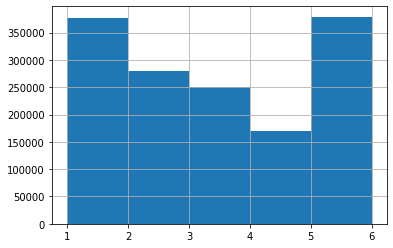

In [64]:
df[~df['is_test']]['spec_len'].hist(bins=5)

In [46]:
df.loc[14].key_skills

array([], dtype=object)

In [40]:
df[df.spec_len >25]

vacancy_id                                               name  \
14          2700017       Администратор хозяйственной службы гостиницы   
21          2700024  Менеджер по продажам / Менеджер по работе с кл...   
62          2700067                              Директор производства   
63          2700068                                          Бухгалтер   
64          2700069  Персональный ассистент (немецкое производство ...   
...             ...                                                ...   
2912591     2695301  Аниматор/ Ведущий мастер-классов/ Вожатый (нов...   
2912605     2696941                          Менеджер интернет-проекта   
2912620     2699078                                           Весовщик   
2912636     2562955                    Менеджер программы Allsubmitter   
2912646     2625465             Модель (дизайн и моделирование ногтей)   

                                               description  area_id  \
14       <p><strong>Стань частью команды Topos Congress...       76   
21       <p>Компания CHIP - одна из ведущих компаний по...       22   
62       <strong>Обязанности:</strong> <ul> <li>общее р...       89   
63       <p><strong>Обязанности:</strong></p> <p>- Обра...        2   
64       <strong>Обязанности:</strong> <p>Организационн...     1990   
...                                                    ...      ...   
2912591  <p><em>КидБург – это Город Профессий для детей...        1   
2912605  <p><em><strong>В связи с реализацией стратегии...        1   
2912620  <strong>Обязанности:</strong> <ul> <li>контрол...     1795   
2912636  <strong>Обязанности:</strong> <p>Работа по про...        1   
2912646  <p>Компания Nika Nagel – это бренд модного сал...       92   

        creation_date work_schedule work_experience  compensation_from  \
14         2019-03-12         shift    noExperience            20000.0   
21         2019-10-02       fullDay    between1And3            35000.0   
62         2019-06-18       fullDay       moreThan6            90000.0   
63         2019-08-13       fullDay    between1And3            34500.0   
64         2019-10-23       fullDay    between3And6            60000.0   
...               ...           ...             ...                ...   
2912591    2019-12-09      flexible    noExperience                NaN   
2912605    2019-10-15       fullDay    between1And3            40000.0   
2912620    2019-06-04       fullDay    noExperience                NaN   
2912636    2019-08-13        remote    between1And3             5000.0   
2912646    2019-04-08      flexible    noExperience                NaN   

         compensation_to currency  \
14                   NaN      RUR   
21                   NaN      RUR   
62                   NaN      RUR   
63               41000.0      RUR   
64                   NaN      RUR   
...                  ...      ...   
2912591              NaN      NaN   
2912605              NaN      RUR   
2912620              NaN      NaN   
2912636          10000.0      RUR   
2912646              NaN      NaN   

                                                key_skills      employer  \
14                                                      []  764a221a6ce7   
21                                                    [1с]  8632324c3155   
62                                                      []  dfcc3d4f8c99   
63                                                      []  4ebefd68b43f   
64       [Английский язык, Электронный документооборот,...  6571a3f53abf   
...                                                    ...           ...   
2912591                                                 []  fa00459c8ed1   
2912605         [Социальные сети, оформление документации]  5727831b855e   
2912620                                                 []  3342738c4046   
2912636  [Пользователь ПК, Высокая скорость печати, рут...  7607dec475c5   
2912646             [ЗАПИСЬ ПО ТЕЛЕФОНУ : 8(4872) 751-451]  0083b19d9145   

                    

In [4]:
specs = json.load(open(os.path.join(data_path, 'specializations.json'), encoding='utf-8'))

In [5]:
len(specs['data'])

28

In [6]:
specs['data']

[{'id': '1',
  'name': 'Информационные технологии, интернет, телеком',
  'specializations': [{'id': '1.395',
    'name': 'Банковское ПО',
    'laboring': False},
   {'id': '1.400', 'name': 'Оптимизация сайта (SEO)', 'laboring': False},
   {'id': '1.420', 'name': 'Администратор баз данных', 'laboring': False},
   {'id': '1.474', 'name': 'Стартапы', 'laboring': False},
   {'id': '1.475', 'name': 'Игровое ПО', 'laboring': False},
   {'id': '1.536', 'name': 'CRM системы', 'laboring': False},
   {'id': '1.744', 'name': 'Другое', 'laboring': False},
   {'id': '1.3', 'name': 'CTO, CIO, Директор по IT', 'laboring': False},
   {'id': '1.9', 'name': 'Web инженер', 'laboring': False},
   {'id': '1.10', 'name': 'Web мастер', 'laboring': False},
   {'id': '1.25', 'name': 'Аналитик', 'laboring': False},
   {'id': '1.30', 'name': 'Арт-директор', 'laboring': False},
   {'id': '1.50',
    'name': 'Системы управления предприятием (ERP)',
    'laboring': False},
   {'id': '1.82', 'name': 'Инженер', 'labo

In [96]:
spec_list = []
spec_2_group = {}
grp_desc = {}
spec_desc = {}
for v in specs['data']:
    sepc_gr = {"gr_id": int(v['id']), "gr_name": v["name"]}
    grp_desc[int(v['id'])] = v["name"]
    for sv in v['specializations']:
        spec_list.append({**sepc_gr, "s_id":int(sv['id'].split('.')[1]), 's_name': sv['name'], 'laboring': sv['laboring']})
        spec_2_group[int(sv['id'].split('.')[1])] = int(v['id'])
        spec_desc[int(sv['id'].split('.')[1])] = sv['name']

In [83]:
df['groups_of_spec'] = df['specializations'].apply(lambda x: list(set([spec_2_group[y] for y in x])) if x is not None else None)

In [84]:
df['len_groups'] = df['groups_of_spec'].apply(lambda x: len(x) if x is not None else None)

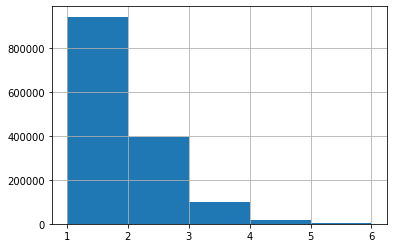

In [85]:
df[~df['is_test']]['len_groups'].hist(bins=5)

In [98]:
df.loc[1803, 'description']

'<p><strong>В команду благотворительной организации &quot;Центр защиты материнства и детства &quot;Теплый дом на горе&quot; требуется руководитель социального отдела. </strong></p> <p><strong>Обязанности:</strong></p> <ul> <li>Приём посетителей</li> <li>Выдача гуманитарной помощи</li> <li>Ведение переговоров</li> <li>Ведение отчетности</li> <li>Предоставление социальной консультации обращающимся в центр</li> <li>Кураторство приюта для женщин</li> <li>Управление персоналом отдела</li> <li>Выполнение поручений руководства</li> <li>Приём звонков</li> <li>Координирование социального отдела</li> </ul> <strong>Требования:</strong> <ul> <li>Грамотная устная и письменная речь</li> <li>Ответственность</li> <li>Пунктуальность</li> <li>Честность</li> <li>Инициативность</li> <li>Умение управлять проектами</li> <li>Умение работать в команде</li> <li>Коммуникабельность</li> <li>Организаторские способности</li> </ul> <strong>Условия:</strong> <ul> <li>График работы 5/2 с 10 до 18 часов. Выходные субб

In [97]:
for i in df.loc[1803, 'specializations']:
    print(spec_desc[i])

PR, Маркетинговые коммуникации
Ресепшен
Управление персоналом
Управляющий офисом (Оffice manager)
Юрисконсульт
Администрация


In [88]:
df[df['len_groups'] == 5]

vacancy_id                                               name  \
482         2700510                                           Официант   
513         2700542                                      Офис-менеджер   
1803        2701902                    Руководитель социального отдела   
4480        2704733                  Менеджер по продажам (call-центр)   
5276        2705587                            Младший бизнес-аналитик   
...             ...                                                ...   
2908870     2694713                               Фасовщик / Упаковщик   
2908936     2696498                                  Тайный покупатель   
2909626     2509724  Intern for International Leadership Developmen...   
2911138     2478222  Разработчик программы ДПО "Учитель информатики...   
2912346     2657479                                 Работник прачечной   

                                               description  area_id  \
482      <p>На постоянную работу в дружный коллектив ре...       88   
513      <p>Архитектурно-строительная компания &quot;Те...       78   
1803     <p><strong>В команду благотворительной организ...       29   
4480     ​​​​​​ <p><strong>Работа на дому!</strong></p>...       70   
5276     <p>Boxberry International является одним из на...        1   
...                                                    ...      ...   
2908870  <strong>Обязанности:</strong> <ul> <li>Фасовка...       88   
2908936  <p>Предлагаем подработку &quot;Тайным покупате...       93   
2909626  <p><strong>Interns for International Leadershi...      125   
2911138  <p><strong>«Академия бизнеса и управления сист...       24   
2912346  <p><strong>МЫ ПРЕДЛАГАЕМ:</strong></p> <p>• Ра...     1641   

        creation_date work_schedule work_experience  compensation_from  \
482        2019-12-17         shift    noExperience                NaN   
513        2019-01-09       fullDay    between3And6            20000.0   
1803       2019-12-03       fullDay    noExperience            15000.0   
4480       2019-09-16        remote    noExperience            25000.0   
5276       2019-12-23       fullDay    between1And3            60000.0   
...               ...           ...             ...                ...   
2908870    2019-04-15      flexible    noExperience                NaN   
2908936    2019-02-27      flexible    noExperience                NaN   
2909626    2019-04-17       fullDay    noExperience                NaN   
2911138    2019-07-12        remote    between3And6                NaN   
2912346    2019-04-10      flexible    noExperience                NaN   

         compensation_to currency  \
482                  NaN      NaN   
513              25000.0      RUR   
1803             15000.0      RUR   
4480             50000.0      RUR   
5276             70000.0      RUR   
...                  ...      ...   
2908870           9000.0      RUR   
2908936              NaN      NaN   
2909626              NaN      NaN   
2911138              NaN      NaN   
2912346              NaN      NaN   

                                                key_skills      employer  \
482                                      [Ответственность]  27287a2ba24b   
513      [Управление офисами компании, Заключение догов...  cae7433d7ed4   
1803     [Управление персоналом, Грамотная речь, Пользо...  b129411de618   
4480                                                    []  849ad7da3feb   
5276     [Аналитика продаж, MS Visio, Конкурентная анал...  04192f0b3396   
...                                                    ...           ...   
2908870                                                 []  f0348bcf96f9   
2908936                                                 []  4c6cbc2324d8   
2909626  [Leadership Skills, Английский язык, Learning ...  9c6c3541275d   
2911138  [разработка программ дпо, дистанционные технол...  2379287d5cbe   
2912346                                                 []  0c0fd1dfdd00   

                    

In [105]:
df_emp = df.groupby('employer')['vacancy_id'].count()

In [109]:
df_emp.shape

(345193,)

In [150]:
# b9031c8c70e3 - Сбер
# 19cf67a46d49 - Магнит
# 400b19f5f5e1 - Fix Price
# 4dff1799dfa2 - K&B
# d9457568e64a - Почта России
# df103f3df511 - Ростелеком
# 52549596ea26 - Перекресток

In [ ]:
df.loc[2912222].description

In [148]:
df[df.employer == '52549596ea26']

vacancy_id                                              name  \
929         2700972                                   Повар (Шишкова)   
1416        2701484                                   Повар (Галерея)   
1424        2701492               Менеджер-аналитик клиентского опыта   
1610        2701694                                     Кассир, Саров   
1676        2701763  Главный инженер по технологическому оборудованию   
...             ...                                               ...   
2908804     2692678                                            Кассир   
2909164     2412593          Стажер (Стажёрская программа RuleMakers)   
2909654     2515246                     Заместитель директора- стажер   
2910638     2405994                         Пекарь (временная работа)   
2912222     2638042                                            Пекарь   

                                               description  area_id  \
929      <p>Ваши задачи:</p> <ul> <li>разделывать мясо,...       26   
1416     <p><strong>Торговая сеть «Перекрёсток» – перех...     1498   
1424     <p><strong>Компания Х5 ТД Перекресток приглаша...        1   
1610     <p>Торговая сеть «Перекрёсток» – переходи на л...      249   
1676     <p>«SMART KITCHEN» - большой современный высок...     2085   
...                                                    ...      ...   
2908804  <p><strong>Торговая сеть «Перекрёсток» – перех...       73   
2909164  <p><strong>Хочешь построить карьеру в крупной ...        3   
2909654  <p><strong>Дай яркий старт своей карьере!</str...       78   
2910638  <strong>Обязанности:</strong> <p>Пекарь – проф...     2086   
2912222  <p> </p> <p>Пекарь – профессия, пришедшая к на...        1   

        creation_date work_schedule work_experience  compensation_from  \
929        2019-02-19         shift    between1And3            30000.0   
1416       2019-03-20       fullDay    between1And3            24000.0   
1424       2019-05-20       fullDay    between1And3                NaN   
1610       2019-04-03       fullDay    noExperience            18000.0   
1676       2019-10-09       fullDay    between1And3                NaN   
...               ...           ...             ...                ...   
2908804    2019-07-04         shift    noExperience            26000.0   
2909164    2019-10-09       fullDay    noExperience                NaN   
2909654    2019-04-24      flexible    noExperience            10000.0   
2910638    2019-05-16         shift    noExperience            29500.0   
2912222    2019-05-16      flexible    noExperience            30000.0   

         compensation_to currency  \
929                  NaN      RUR   
1416             28000.0      RUR   
1424                 NaN      NaN   
1610             20000.0      RUR   
1676                 NaN      NaN   
...                  ...      ...   
2908804              NaN      RUR   
2909164              NaN      NaN   
2909654              NaN      RUR   
2910638          34500.0      RUR   
2912222              NaN      RUR   

                                                key_skills      employer  \
929                                                     []  52549596ea26   
1416                                                    []  52549596ea26   
1424     [Построение покупательского пути (CJM процессо...  52549596ea26   
1610                                                    []  52549596ea26   
1676     [Обучение персонала, Управление персоналом, Уп...  52549596ea26   
...                                                    ...           ...   
2908804                                                 []  52549596ea26   
2909164                                                 []  52549596ea26   
2909654                                                 []  52549596ea26   
2910638                                                 []  52549596ea26   
2912222                                                 []  52549596ea26   

                 specializations

In [19]:
df['desc_low'] = df.description.str.lower()

In [ ]:
df[~df['desc_low'].str.contains('обязанности')]

In [147]:
df_emp[(df_emp < 5000) & (df_emp > 4000)]

employer
52549596ea26    4118
55933aefb06e    4129
aae45f8e80f1    4794
e8c0a0ce88e4    4497
f1f5bf1f05a9    4231
Name: vacancy_id, dtype: int64

In [23]:
spec_df = pd.DataFrame(spec_list)

In [5]:
spec_list = df[df.is_test == False].specializations.to_list()

In [10]:
import functools
import operator

In [12]:
ful_spec = set(functools.reduce(operator.iconcat, spec_list, []))

In [13]:
len(ful_spec)

620

In [ ]:
spec_list = sum(spec_list,[])

In [24]:
spec_df.head()

gr_id                                       gr_name  s_id  \
0      1  Информационные технологии, интернет, телеком   395   
1      1  Информационные технологии, интернет, телеком   400   
2      1  Информационные технологии, интернет, телеком   420   
3      1  Информационные технологии, интернет, телеком   474   
4      1  Информационные технологии, интернет, телеком   475   

                     s_name  laboring  
0             Банковское ПО     False  
1   Оптимизация сайта (SEO)     False  
2  Администратор баз данных     False  
3                  Стартапы     False  
4                Игровое ПО     False

In [25]:
spec_df.to_excel('spec_data.xls')

In [71]:
df.drop(columns=['vacancy_id','name', 'description', 'key_skills'], inplace = True)